In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn import linear_model
import pandas as pd

In [2]:
def pinball_loss(data, quant_preds, quantiles):
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [3]:
# meter_id = 56
# finals_df = pd.read_csv(".\\GEFCom2017\\GEFCom2017-Final\\load.csv")
# finals_df = finals_df[finals_df.meter_id==meter_id]

In [4]:
# finals_df

In [5]:
# loads = finals_df.iloc[:, 2:].to_numpy()
# loads = loads.reshape(loads.size)
# dates = finals_df.date.to_numpy().repeat(24)

In [6]:
# temps_df = pd.read_csv(".\\GEFCom2017\\GEFCom2017-Final\\temperature.csv")

In [7]:
# offset = 0
# i = 0
# while i < loads.shape[0]:
#     if i % 24 + 1 != temps_df.hr.iloc[i]:
#         print(i, temps_df.hr.iloc[i])
#         idxs = temps_df.index.to_numpy()
#         idxs[i:] += 1
#         temps_df.index = idxs
#         fake_data = (temps_df.loc[i - 1].iloc[1:] + temps_df.loc[i + 1].iloc[1:]) // 2
#         fake_data = pd.DataFrame(fake_data).transpose()
#         fake_data.index = [i]
#         temps_df = temps_df.append(fake_data, sort=True)
#         temps_df.date[i] = temps_df.date[i + 1]
#         temps_df = temps_df.sort_index()
#         i += 1
#     i += 1

In [101]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json", "r") as f:
    alldata = json.loads(f.read())

In [154]:
zone_data = alldata["ISONE CA"]

In [155]:
all_df = pd.DataFrame({"date": zone_data["Date"], "load": zone_data["DEMAND"], "temp": zone_data["DryBulb"]})

In [156]:
all_df.date = pd.to_datetime(all_df.date)
train_start = all_df.index[list(date.month == 7 for date in all_df.date)][0]
start_date = all_df.date.iloc[train_start]
train_through = all_df[all_df.date == start_date.replace(year=start_date.year + 10)].index[0]

In [157]:
all_df["day_of_week"] = list((i // 24) % 7 for i in range(len(all_df)))
all_df["hour_end"] = list(i % 24 + 1 for i in range(len(all_df)))
all_df["month"] = list(all_df.date.loc[i].month for i in all_df.index)
all_df["day_of_year"] = list(date.timetuple().tm_yday for date in all_df.date)
all_df["year"] = list(date.timetuple().tm_year for date in all_df.date)

In [158]:
all_df

,date,load,temp,day_of_week,hour_end,month,day_of_year,year
0,2005-01-01,12118.0,44,0,1,1,1,2005
1,2005-01-01,11385.0,44,0,2,1,1,2005
2,2005-01-01,10847.0,43,0,3,1,1,2005
3,2005-01-01,10576.0,41,0,4,1,1,2005
4,2005-01-01,10505.0,42,0,5,1,1,2005
...,...,...,...,...,...,...,...,...
96403,2015-12-31,15048.0,39,5,20,12,365,2015
96404,2015-12-31,14361.0,38,5,21,12,365,2015
96405,2015-12-31,13635.0,38,5,22,12,365,2015
96406,2015-12-31,12900.0,37,5,23,12,365,2015


In [159]:
bad_idxs = all_df.load.isnull().to_numpy().nonzero()[0]
all_df.loc[bad_idxs, "load"] = (all_df.load.values[bad_idxs - 1] + all_df.load.values[bad_idxs + 1]) / 2

In [160]:
all_df.loc[bad_idxs, "load"]

Series([], Name: load, dtype: float64)

In [161]:
variables = pd.DataFrame(all_df.temp)

In [162]:
variables["temp2"] = variables.temp ** 2
variables["temp3"] = variables.temp ** 3
variables["trend"] = variables.index

for i in range(2, 13):
    variables[f"m{i}"] = (i == all_df.month) * 1  # converts to int
    variables[f"tempmonth{i}"] = variables.temp * variables[f"m{i}"]
    variables[f"temp2month{i}"] = variables.temp2 * variables[f"m{i}"]
    variables[f"temp3month{i}"] = variables.temp3 * variables[f"m{i}"]

for i in range(2, 25):
    variables[f"h{i}"] = (i == all_df.hour_end) * 1
    variables[f"temphour{i}"] = variables.temp * variables[f"h{i}"]
    variables[f"temp2hour{i}"] = variables.temp2 * variables[f"h{i}"]
    variables[f"temp3hour{i}"] = variables.temp3 * variables[f"h{i}"]

for i in range(1, 7):
    variables[f"w{i}"] = (i == all_df.day_of_week) * 1
    
for i in range(1, 7):
    for j in range(2, 25):
        variables[f"wh{i}_{j}"] = variables[f"w{i}"] * variables[f"h{j}"]

# Train

In [163]:
cap = train_through
train_df = all_df.iloc[train_start:cap]
train_vars = variables.iloc[train_start:cap]

In [164]:
train_vars.iloc[:50]

,temp,temp2,temp3,trend,m2,tempmonth2,temp2month2,temp3month2,m3,tempmonth3,...,wh6_15,wh6_16,wh6_17,wh6_18,wh6_19,wh6_20,wh6_21,wh6_22,wh6_23,wh6_24
4344,67,4489,300763,4344,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4345,66,4356,287496,4345,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4346,66,4356,287496,4346,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4347,66,4356,287496,4347,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4348,65,4225,274625,4348,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4349,65,4225,274625,4349,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4350,65,4225,274625,4350,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4351,66,4356,287496,4351,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4352,66,4356,287496,4352,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4353,67,4489,300763,4353,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
reg = linear_model.LinearRegression()

reg.fit(train_vars, train_df.load)

LinearRegression()

<IPython.core.display.Javascript object>


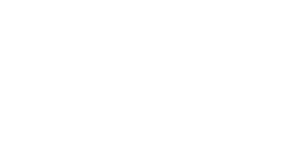

In [166]:
%matplotlib notebook 
fit = reg.predict(variables)
plt.figure()
plt.plot(all_df.load.values)
plt.plot(fit)
plt.axvline(train_through, color="k")
plt.show()

# Test

In [167]:
#  ###---TEST---###
gap = 0 * 24
test_length = 31 * 24
start = train_through + gap
cap = train_through + test_length + gap
test_demand = all_df.load[start:cap]
test_days_of_year = np.unique(all_df.day_of_year.iloc[start:cap].values)

temps = []
years = np.unique(train_df.year)
num_years = len(years)
k = int((99 / num_years - 1) / 2 + 0.5)
print("k =", k)
for yr in years:
    this_year = all_df.iloc[:train_through][all_df.year.iloc[:train_through] == yr]
    for shift in range(-k, k + 1):
        include = list(day + shift in test_days_of_year for day in this_year.day_of_year)
        temps.append(this_year.temp[include].values)

k = 4


In [169]:
np.mean(temps)

73.51913082437277

In [170]:
np.array(temps).shape

(90, 744)

In [171]:
diff = np.mean(temps, axis=0) - variables.temp[start:cap].values

<IPython.core.display.Javascript object>


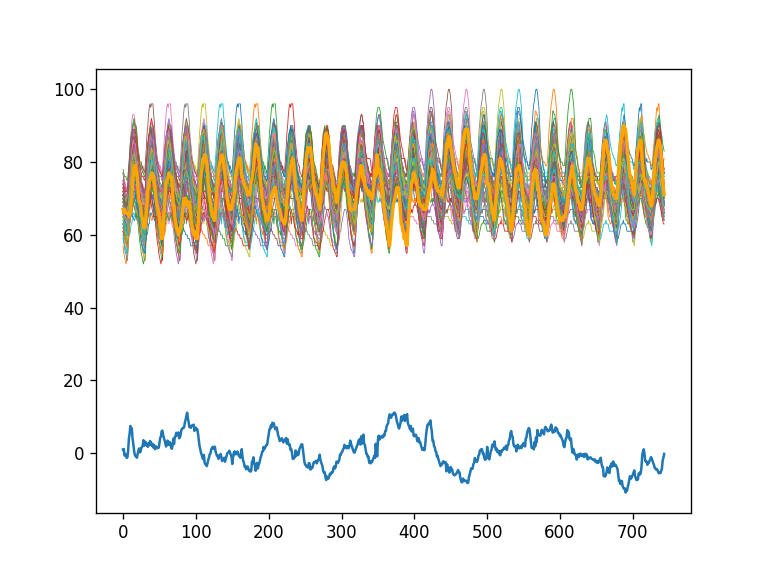

In [172]:
%matplotlib notebook
plt.plot(np.array(temps).T, linewidth=0.5)
plt.plot(variables.temp[start:cap].values, linewidth=2, color="orange")
plt.plot(diff)
plt.show()

In [173]:
preds = []
for i, temp in enumerate(temps):
    test_vars = variables.iloc[start:cap].copy()
    
    test_vars.loc[:, "temp"] = temp
    test_vars.loc[:, "temp2"] = temp ** 2
    test_vars.loc[:, "temp3"] = temp ** 3

    for i in range(2, 13):
        test_vars.loc[:, f"tempmonth{i}"] = test_vars.temp * test_vars[f"m{i}"]
        test_vars.loc[:, f"temp2month{i}"] = test_vars.temp2 * test_vars[f"m{i}"]
        test_vars.loc[:, f"temp3month{i}"] = test_vars.temp3 * test_vars[f"m{i}"]

    for i in range(2, 25):
        test_vars.loc[:, f"temphour{i}"] = test_vars.temp * test_vars[f"h{i}"]
        test_vars.loc[:, f"temp2hour{i}"] = test_vars.temp2 * test_vars[f"h{i}"]
        test_vars.loc[:, f"temp3hour{i}"] = test_vars.temp3 * test_vars[f"h{i}"]
        
    preds.append(reg.predict(test_vars))

preds = np.array(preds)

In [174]:
test_vars.columns

Index(['temp', 'temp2', 'temp3', 'trend', 'm2', 'tempmonth2', 'temp2month2',
       'temp3month2', 'm3', 'tempmonth3',
       ...
       'wh6_15', 'wh6_16', 'wh6_17', 'wh6_18', 'wh6_19', 'wh6_20', 'wh6_21',
       'wh6_22', 'wh6_23', 'wh6_24'],
      dtype='object', length=284)

In [175]:
# test_vars.iloc[1000:1050, -100:-80]

<IPython.core.display.Javascript object>


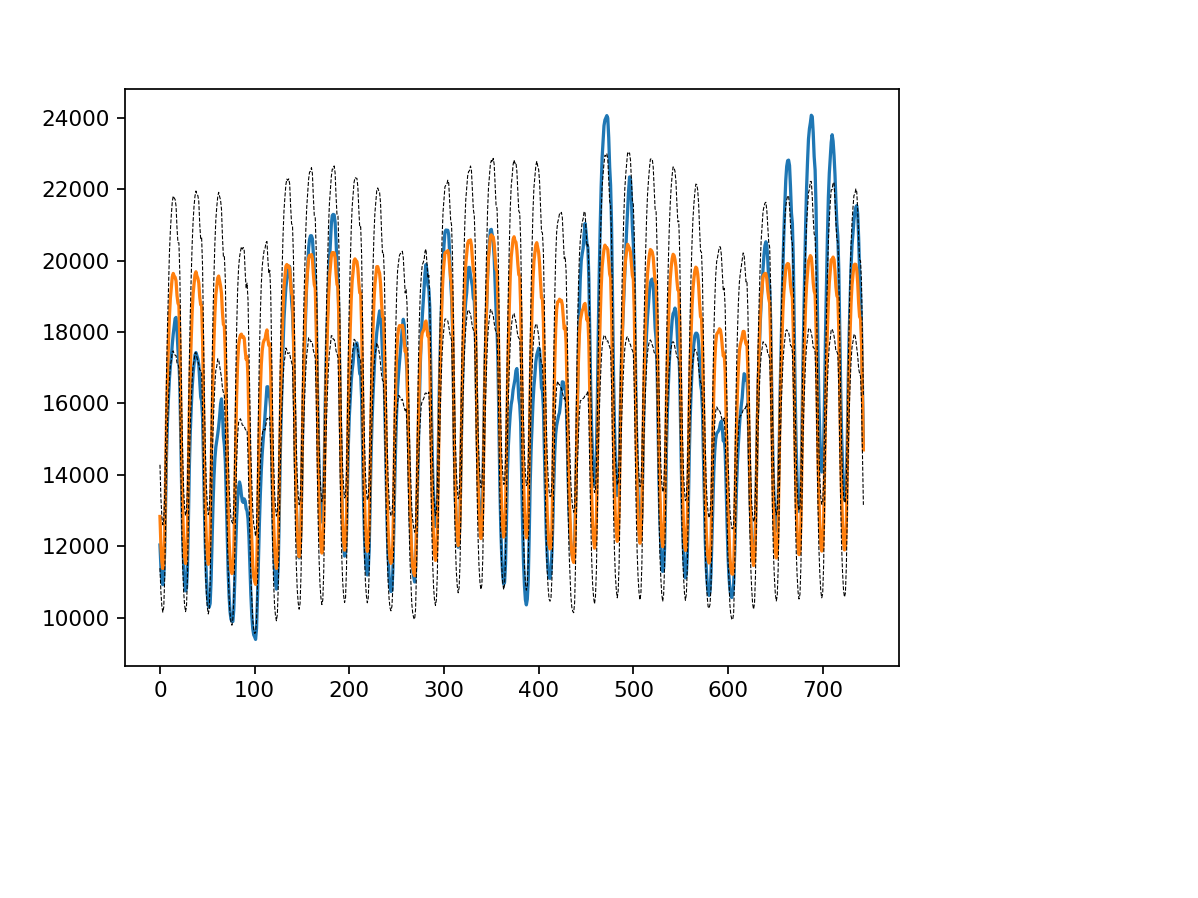

In [176]:
pred = np.mean(preds, axis=0)
std = np.std(preds, axis=0)
plt.figure(dpi=130)
plt.plot(test_demand.values)
plt.plot(pred)
plt.plot(std + pred, linestyle="--", color="black", linewidth=0.5)
plt.plot(pred - std, linestyle="--", color="black", linewidth=0.5)
plt.show()

In [177]:
quant_preds = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in range(preds.shape[1]):
    sorted_preds = np.sort(preds[:, t])
    quant_pred = []
    for q in quantiles:
        idx = int(q * preds.shape[0] + 0.5)
        quant_pred.append(sorted_preds[idx])
    quant_preds.append(quant_pred)

In [178]:
print(quant_preds[100])

[9212.006975290516, 9628.564388897348, 10008.529446451028, 10466.874056317121, 11000.65947008992, 11294.924119564448, 11606.94693936347, 12282.79771573199, 13025.27305078964]


In [179]:
pinball_loss(test_demand.values, quant_preds, quantiles)

544.7284618154562